In [1]:
import requests
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

## Get and read in data

In [2]:
city = 'fargo'
state = 'nd'
%run zillow_data_scrape.py fargo nd

Scraping data...
Done.
Fargo_Homes_ForSale.csv is available for viewing.
Fargo_Apartments_ForRental.csv is available for viewing.


In [114]:
df = pd.read_csv("./data/" + city + "_Homes_ForSale.csv")
df2 = pd.read_csv("./data/" + city + "_Apartments_ForRental.csv")

null_price = df[df["unformattedPrice"].isnull()]
null_price2 = df2[df2["unformattedPrice"].isnull()]
df.drop(null_price.index, inplace=True)
df2.drop(null_price2.index, inplace=True)

#set zestimate equal to price if 0, set best_deal equal to division
df.loc[(df['zestimate'].isnull()) | (df['zestimate'] == 0), 'zestimate'] = df['unformattedPrice']
df['best_deal'] = df['zestimate'] - df['unformattedPrice']
df.sort_values("best_deal")

df2.loc[(df2['zestimate'].isnull()) | (df2['zestimate'] == 0), 'zestimate'] = df2['unformattedPrice']
df2['best_deal'] = df2['zestimate'] - df2['unformattedPrice']
df2.sort_values("unformattedPrice")
df.head()

,Unnamed: 0,zpid,imgSrc,statusType,price,unformattedPrice,zestimate,best_deal,address,addressZipcode,beds,baths,area,variableData,brokerName,builderName
0,61,98773916,https://photos.zillowstatic.com/fp/ad0bb78ddad...,FOR_SALE,"$249,900",249900,254153,4253,"4709 Harvest Dr S, Fargo, ND 58104",58104,3.0,2.0,2086.0,"{'type': 'DAYS_ON', 'text': '14 days on Zillow'}",eXp Realty (219 WF),NaN
1,100,123901535,https://photos.zillowstatic.com/fp/f96bd0383bd...,FOR_SALE,"$247,000",247000,251204,4204,"4328 39 1/2 Ave S, Fargo, ND 58104",58104,3.0,2.0,1968.0,"{'type': 'DAYS_ON', 'text': '18 days on Zillow'}",Krabbenhoft Real Estate Team,NaN
2,365,123900036,https://photos.zillowstatic.com/fp/186cf51b593...,FOR_SALE,"$237,500",237500,241542,4042,"3311 Jefferson St S, Fargo, ND 58104",58104,3.0,2.0,1686.0,"{'type': 'DAYS_ON', 'text': '6 days on Zillow'}",RE/MAX Legacy Realty,NaN
3,104,82538231,https://photos.zillowstatic.com/fp/676cd01942a...,FOR_SALE,"$105,000",105000,109000,4000,"341 Prairiewood Cir S APT 301, Fargo, ND 58103",58103,2.0,1.0,922.0,"{'type': 'PRICE_REDUCTION', 'text': '$4,000 (A...",REAL,NaN
4,350,66538338,https://photos.zillowstatic.com/fp/eabdd58bce9...,FOR_SALE,"$234,900",234900,238800,3900,"1932 53rd Ave S, Fargo, ND 58104",58104,4.0,2.0,1800.0,"{'type': 'DAYS_ON', 'text': '25 days on Zillow'}",Krabbenhoft Real Estate Team,NaN


## Homes

#### averages of price and best deal

In [4]:
home_averages = df.copy()

# Step 1: Select columns of number home_averages type
num_cols = home_averages.select_dtypes(include=['int', 'float']).drop(['zpid', 'addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()
median_row = num_cols.median()
mode_row = num_cols.mode()

mean_row = pd.DataFrame(mean_row)
mean_row = mean_row.transpose()

median_row = pd.DataFrame(median_row)
median_row = median_row.transpose()

mode_row = pd.DataFrame(mode_row)
mode_row = mode_row.head(1)

# Step 3: Append new row to home_averagesframe
home_averages = home_averages.append(mean_row, ignore_index=True)
home_averages = home_averages.append(median_row, ignore_index=True)
home_averages = home_averages.append(mode_row, ignore_index=True)

home_averages = home_averages.round(decimals = 2)

home_averages = home_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

home_averages = home_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
home_averages['name'] = names

# create a new column with the same values as the "name" column
new_col = home_averages['name']

# remove the original "name" column
home_averages = home_averages.drop('name', axis=1)

# add the new column in the first position
home_averages.insert(0, 'name', new_col)

print('Average House For Sale in '+ city + ':' )
home_averages

Average House For Sale in Fargo:


,name,unformattedPrice,zestimate,best_deal,beds,baths,area
326,Mean,427863.57,424563.33,-3300.24,3.3,2.57,2345.1
327,Median,379950.00,379950.00,0.00,3.0,3.00,2114.0
328,Mode,98900.00,98900.00,0.00,4.0,3.00,2040.0


In [5]:
## Histogram of prices

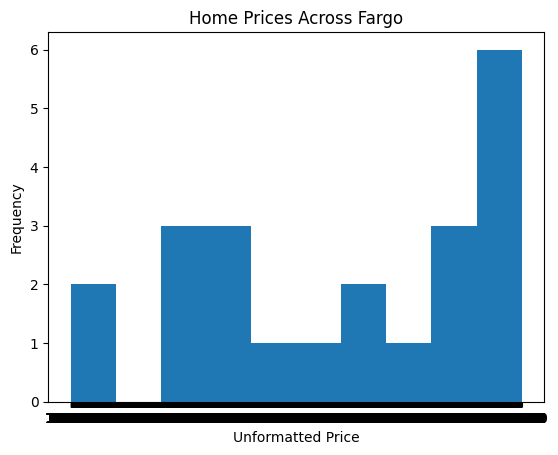

In [6]:
plt.hist(df['unformattedPrice'], bins=10, range=(110000, 160000))
plt.xlabel('Unformatted Price')
plt.ylabel('Frequency')
plt.title('Home Prices Across '+ city)
plt.xticks(range(110000, 160000, 10))
plt.show()

#### Pie chart of builders

In [ ]:
builders = df.copy()

#builders["builderName"].fillna("Not Listed", inplace=True)
builders['builderName'] = builders['builderName'].str.replace(', llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace('llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace(', inc', '', case=False)


builder_counts = pd.DataFrame(builder_counts)

builder_counts.index = 'other'

if builder_counts.values < 1:
    builder_counts.index = 'other'

    
# extract values and index of pandas series
data = builder_counts.values
labels = builder_counts.index

# define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(data)]

# create pie chart
sns.set(rc={"figure.figsize":(40, 12)})
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.title("Construction Companies' Share of Houses Currently Available for Sale in "+ city)
plt.show()# create pandas series of counts of unique values in "builderName" column
builder_counts = builders['builderName'].value_counts(normalize=True) * 100


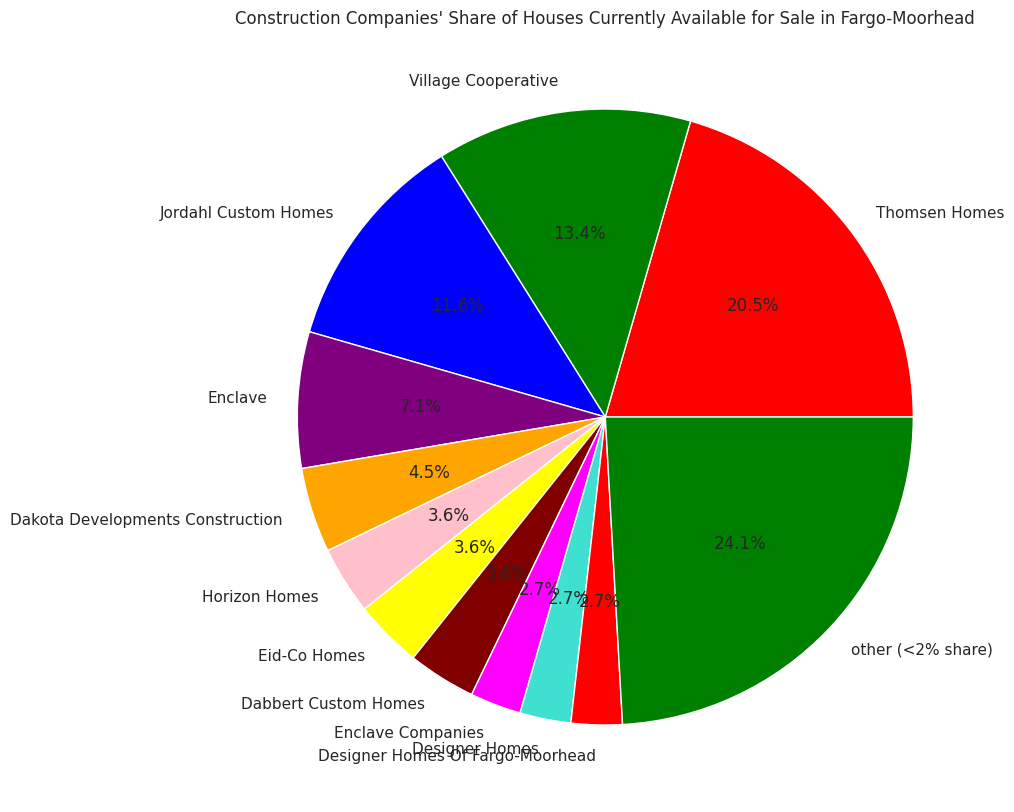

In [178]:
builders = df.copy()

#builders["builderName"].fillna("Not Listed", inplace=True)
builders['builderName'] = builders['builderName'].str.replace(', llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace('llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace(', inc', '', case=False)

# create pandas series of counts of unique values in "builderName" column
builder_count = builders["builderName"].value_counts()

total = builder_count.sum()
threshold = 0.02

builder_percent = builder_count/builder_count.sum()

other_percent = builder_percent[builder_percent < threshold].sum()
builder_percent = builder_percent[builder_percent >= threshold]
builder_percent["other (<2% share)"] = other_percent

builder_percent.plot.pie(figsize=(20, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead")
plt.ylabel("")
plt.show()

In [9]:
## Pie chart of brokers

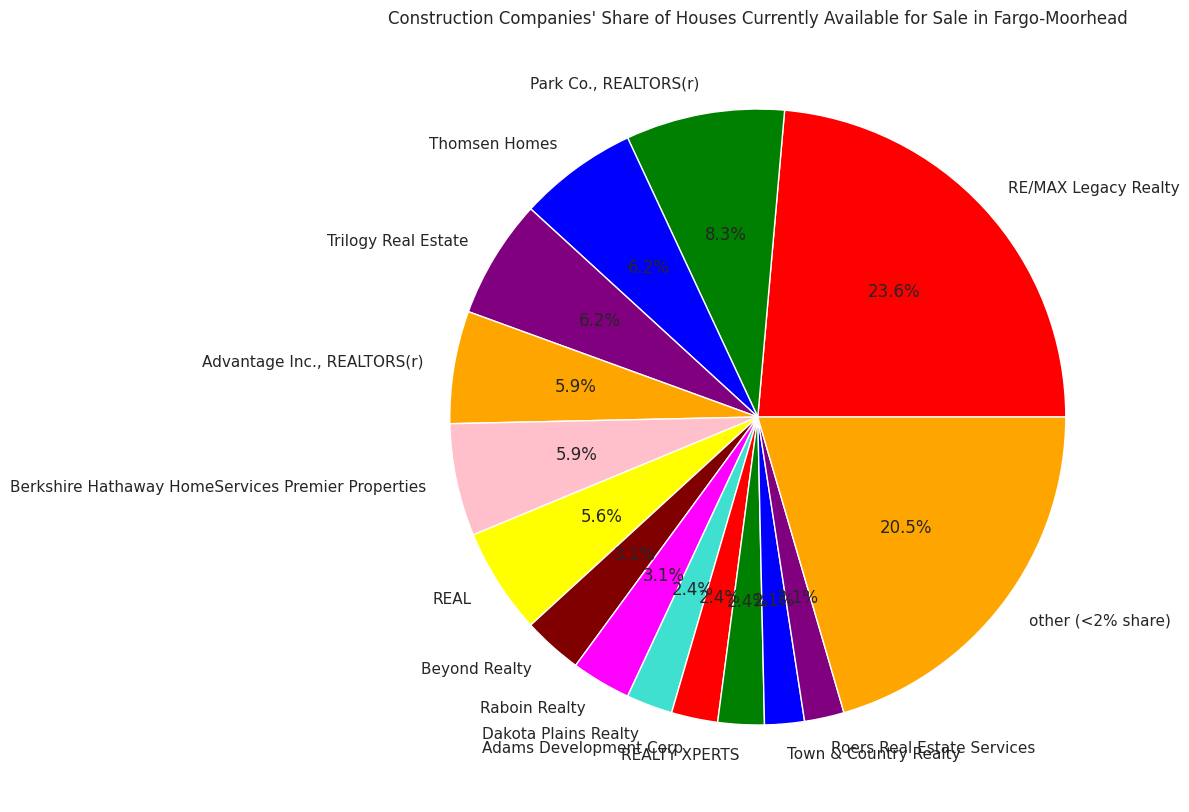

In [177]:
brokers = df.copy()

#brokers["brokerName"].fillna("Not Listed", inplace=True)
brokers['brokerName'] = brokers['brokerName'].str.replace(', llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace('llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace(', inc', '', case=False)

# create pandas series of counts of unique values in "brokerName" column
broker_count = brokers["brokerName"].value_counts()

total = broker_count.sum()
threshold = 0.02

broker_percent = broker_count/broker_count.sum()

other_percent = broker_percent[broker_percent < threshold].sum()
broker_percent = broker_percent[broker_percent >= threshold]
broker_percent["other (<2% share)"] = other_percent

broker_percent.plot.pie(figsize=(20, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead")
plt.ylabel("")
plt.show()

In [12]:
## Beds and Baths

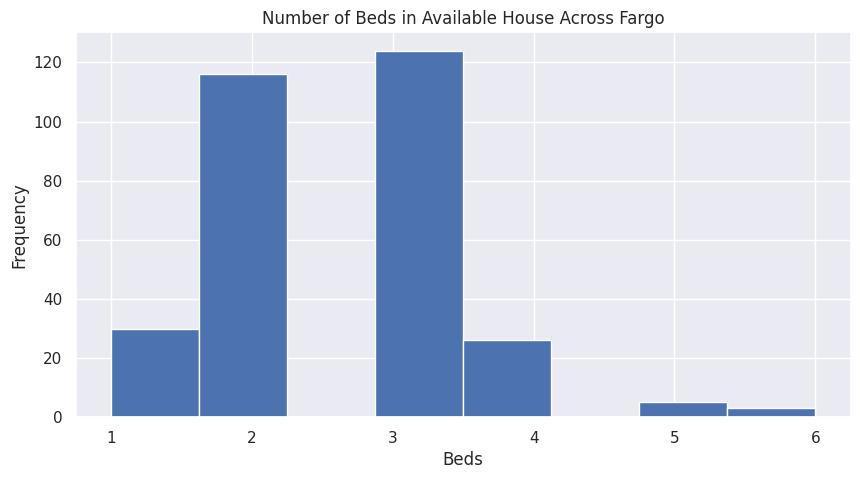

In [42]:
sns.set(rc={"figure.figsize":(10, 5)})
num_beds = int(df['beds'].max())
plt.hist(df['baths'], bins=num_beds)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Available House Across '+city)
plt.show()

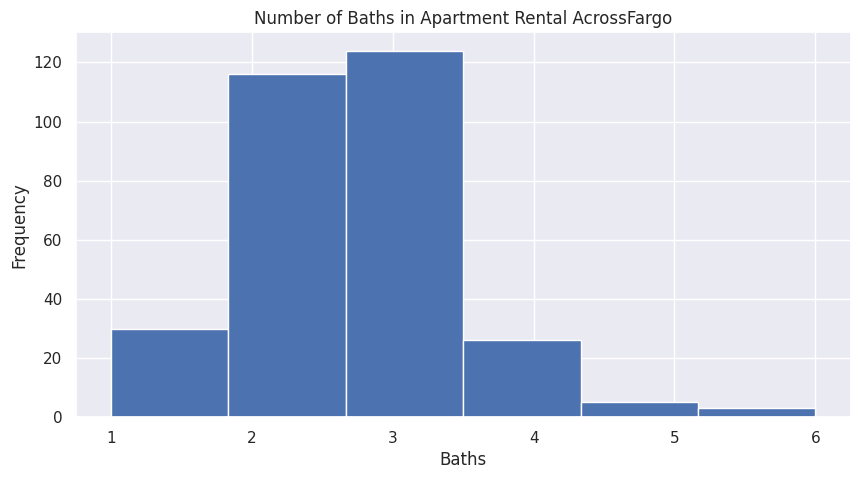

In [34]:
sns.set(rc={"figure.figsize":(10, 5)})
num_bins = int(df['baths'].max())
plt.hist(df['baths'], bins=num_bins)
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across'+ city)
plt.show()

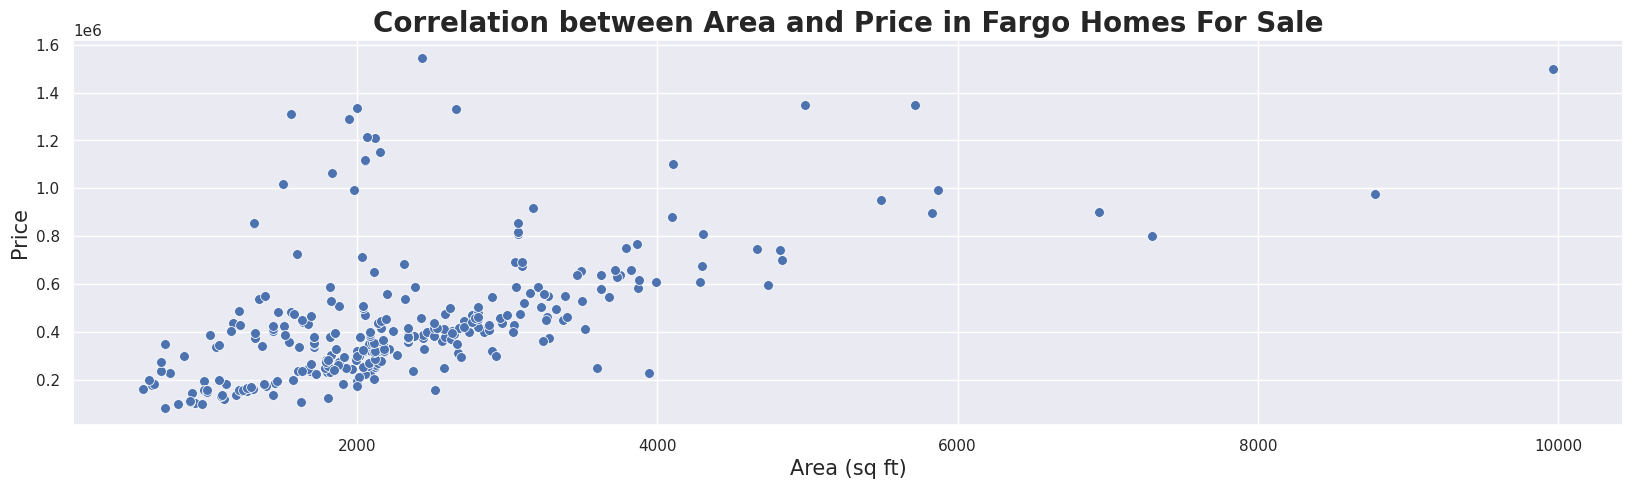

In [15]:
#Scatter plot comparing Area with Price
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Homes For Sale", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()

## Apartments

In [16]:
## averages of price and best deal

In [17]:
apt_averages = df2.copy()

# Step 1: Select columns of number apt_averages type
num_cols = apt_averages.select_dtypes(include=['int', 'float']).drop(['addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()
median_row = num_cols.median()
mode_row = num_cols.mode()

mean_row = pd.DataFrame(mean_row)
mean_row = mean_row.transpose()

median_row = pd.DataFrame(median_row)
median_row = median_row.transpose()

mode_row = pd.DataFrame(mode_row)
mode_row = mode_row.head(1)

# Step 3: Append new row to apt_averagesframe
apt_averages = apt_averages.append(mean_row, ignore_index=True)
apt_averages = apt_averages.append(median_row, ignore_index=True)
apt_averages = apt_averages.append(mode_row, ignore_index=True)

apt_averages = apt_averages.round(decimals = 2)

apt_averages = apt_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

apt_averages = apt_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
apt_averages['name'] = names

# create a new column with the same values as the "name" column
new_col = apt_averages['name']

# remove the original "name" column
apt_averages = apt_averages.drop('name', axis=1)

# add the new column in the first position
apt_averages.insert(0, 'name', new_col)

print('Average Apartment For Rental in '+ city + ': ')
apt_averages

Average Apartment For Rental in Fargo: 


,name,unformattedPrice,zestimate,best_deal,beds,baths,area
51,Mean,836.67,836.67,0.0,1.73,1.19,1016.27
52,Median,750.00,750.00,0.0,2.00,1.00,873.00
53,Mode,695.00,695.00,0.0,2.00,1.00,800.00


In [18]:
## Histogram of price

In [19]:
df2['unformattedPrice'].min()

395.0

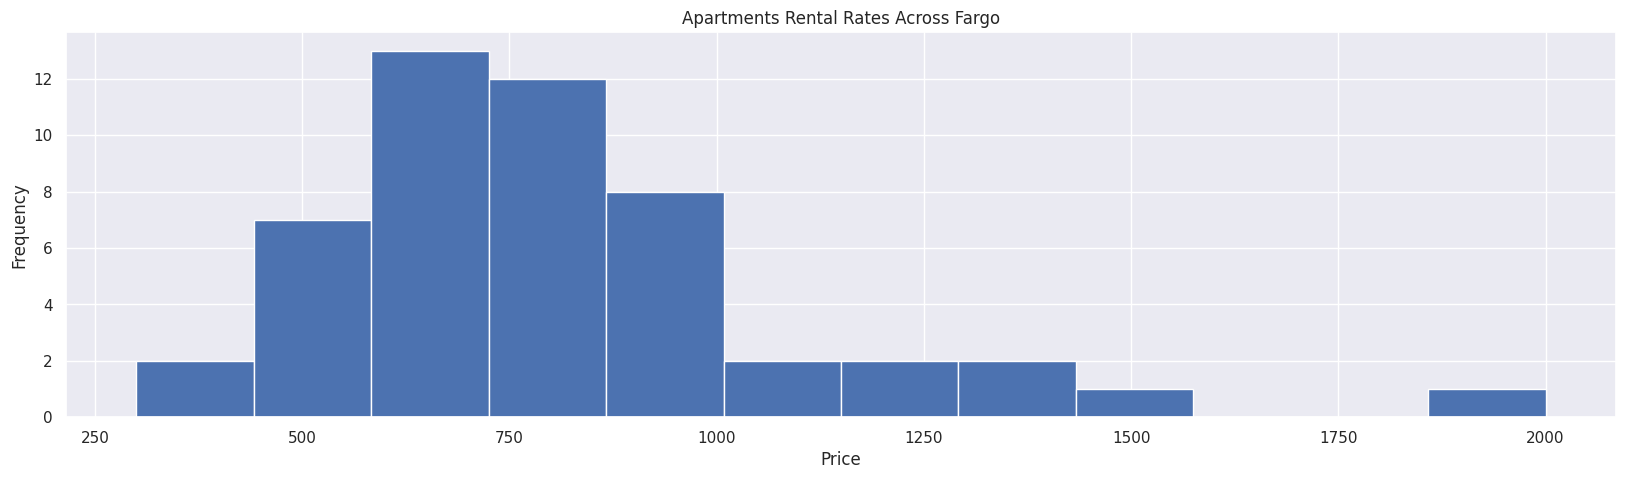

In [20]:
plt.hist(df2['unformattedPrice'], bins=12, range=(300, 2000))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Apartments Rental Rates Across ' + city)
plt.show()

In [21]:
## beds, baths, and area

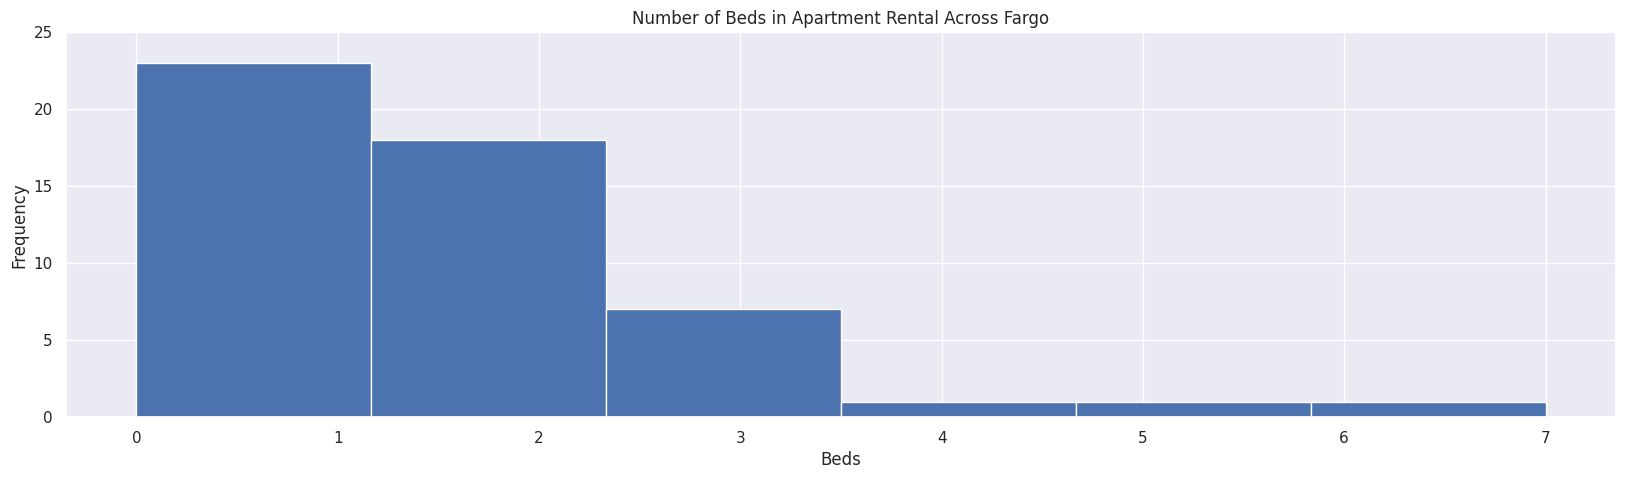

In [22]:
plt.hist(df2['beds'], bins=6, range={0,7})
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Apartment Rental Across '+ city)
plt.ylim(0, 25)
plt.show()

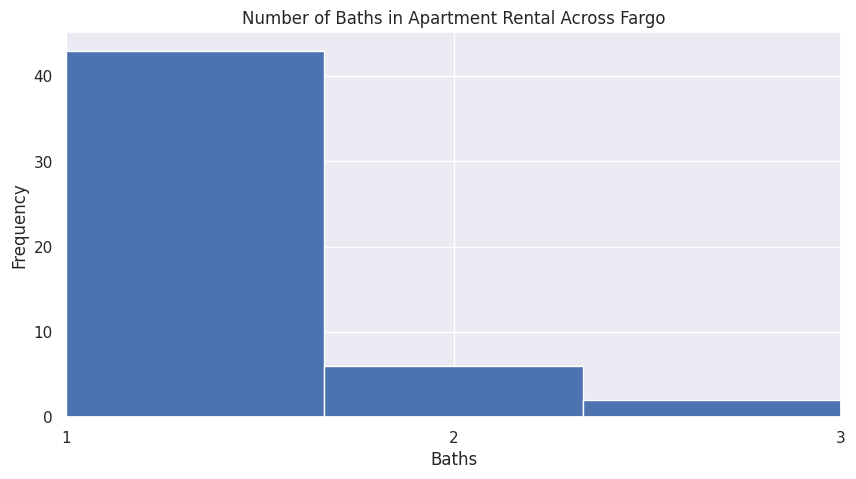

In [23]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.hist(df2['baths'], bins=3, range={1,3})
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across '+city)
plt.xlim(1, 3)
plt.xticks(range(1, 4, 1))
plt.show()

In [24]:
## Pie chart of builders

In [25]:
## Pie chart of brokers

In [26]:
## Pie chart of open house

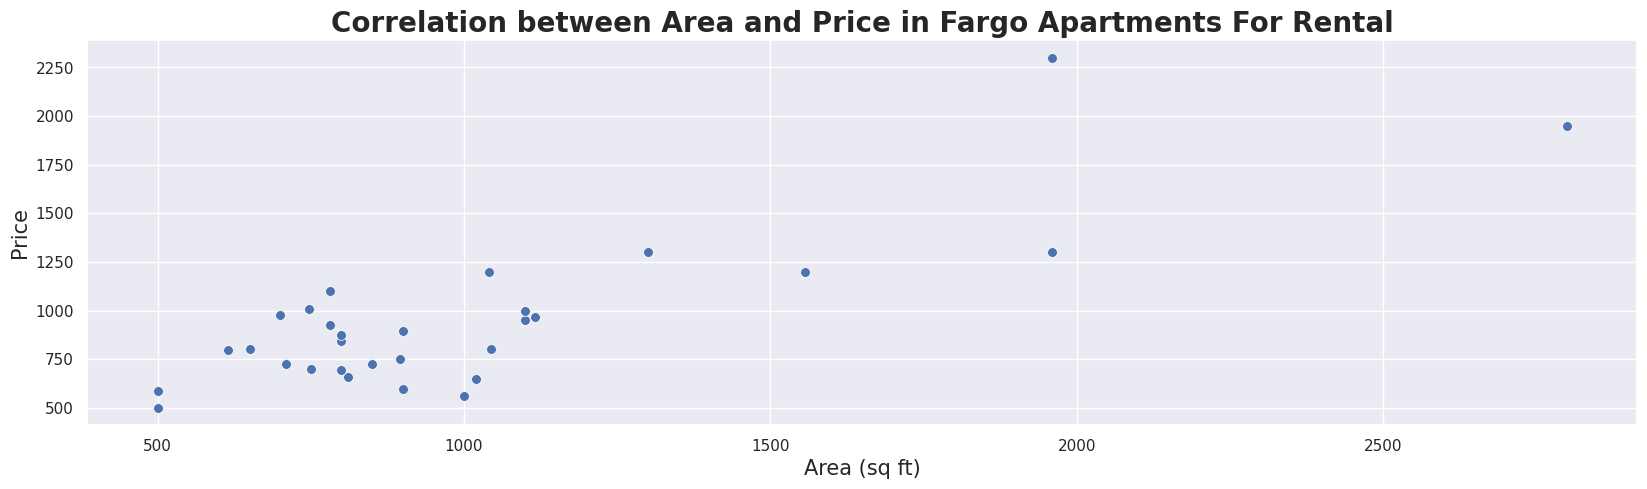

In [27]:
#Scatter plot comparing Area with Price
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df2, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Apartments For Rental", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()